# Acceptance analysis of Direct Air Capture and Storage

Documentation of the analysis.

## Overview and correlation matrix

In the first part, we compute certain mean values of groups of questions and plot the correlation matrix:

In [ ]:
import numpy as np
from dacstore.utils import get_data, ensure_floats, get_data
from dacstore.config import encoding, replacer, weighting_groups, analyze_cols
from dacstore.dac_analysis import compute_group_averages, set_no_knowledge_to_neutral
import seaborn as sns
import matplotlib.pyplot as plt

cols = [
    "climate_change_perception",
    "tampering_with_nature",
    "maturity_of_technology",
    "benefit_perception",
    "cost",
    "risk",
    "trust",
    "emotion",
    "distance",
    "dac_knowledge",
    "storage_knowledge",
    "initial_storage_support",
    "final_storage_support",
    "initial_dac_support",
    "final_dac_support",
    "age",
    "gender",
    "education",
    "occupation",
    "state",
]

independent = [
    "final_dac_support",
    "final_storage_support",
    "initial_storage_support",
    "initial_dac_support",
]


def create_numeric_data(df):
    """Create numeric data for regressions"""
    df = df.replace(replacer)
    df = ensure_floats(df, weighting_groups)
    df = compute_group_averages(df, weighting_groups)
    return df


# we work here with the original column names, no translation
# also, we replace no knowledge with neutral answers and drop invalid entries
df = get_data(
    source="../data/data.csv",
    drop=True,
    translate=False,
    drop_invalid=True,
    no_knowledge_to_neutral=True,
    set_dependent=True,
)

# an invalid entry (completed but more than 24hr completion time)
df = df.drop(91621021)

# numerica data is created by replacing likert scales with numeric values
# and creating group averages for the weighting groups to create categorical data
df = create_numeric_data(df)
df = df[weighting_groups.keys()]
df = df[~df.isna().any(axis=1)]
df = df[cols]

# we need to drop the dependent variables from the independent variables
X = df[[c for c in df.columns if c not in independent]]

setting dependent question values...


/var/folders/8c/6_nbcgds5cs7nphln4chj4vh0000gp/T/ipykernel_12674/2309790110.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(replacer)


Let's have a look at the correlation matrix:

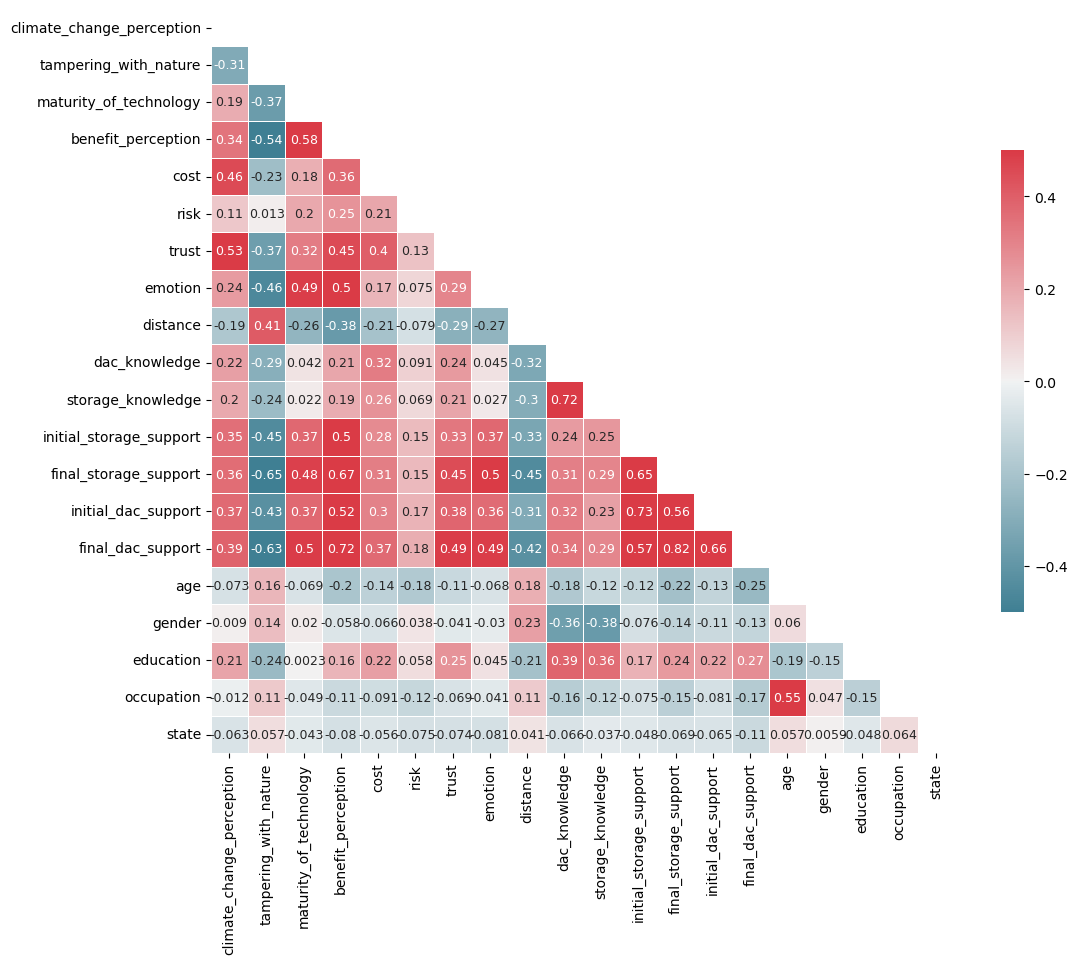

In [11]:
# Create the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# More details at https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(
    corr,  # The data to plot
    mask=mask,  # Mask some cells
    cmap=cmap,  # What colors to plot the heatmap as
    annot=True,  # Should the values be plotted in the cells?
    vmax=0.5,  # The maximum value of the legend. All higher vals will be same color
    vmin=-0.5,  # The minimum value of the legend. All lower vals will be same color
    center=0,  # The center value of the legend. With divergent cmap, where white is
    square=True,  # Force cells to be square
    linewidths=0.5,  # Width of lines that divide cells
    cbar_kws={
        "shrink": 0.5
    },  # Extra kwargs for the legend; in this case, shrink by 50%
    annot_kws={"fontsize": 9},
)

f.savefig("../figs/correlation_matrix.png")

## Creating the model

In the first part, we check for multicollinearity to check for high correlation between independen variables:

In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


def multicollinearity(X):
    """Check for multicollinearity"""
    # Check for multicollinearity using VIF
    X = sm.add_constant(X)  # Add a constant to the model (intercept)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    return vif_data


def create_ols_model(y, X):
    """Create an OLS model"""
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model


multicollinearity(X)

,feature,VIF
0,const,206.359650
1,climate_change_perception,1.605236
2,tampering_with_nature,1.800461
3,maturity_of_technology,1.716093
4,benefit_perception,2.292909
5,cost,1.469598
6,risk,1.174192
7,trust,1.681126
8,emotion,1.585155
9,distance,1.381049


This seems to be a good model, as all VIF values are below 5.0. Next, let's define our independent variables that we want to model. These are the final support of DAC after the survey was completed and the responders had all information they needed. We do the same investigation for the support of CO2 storage.

### DAC support

First, we create a model for the final DAC support.

In [49]:
create_ols_model(df["final_dac_support"], X).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      final_dac_support   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     167.0
Date:                Fri, 15 Nov 2024   Prob (F-statistic):          3.08e-310
Time:                        11:40:28   Log-Likelihood:                -1433.5
No. Observations:                1416   AIC:                             2901.
Df Residuals:                    1399   BIC:                             2990.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.7966      0.256      3.114      0.002       0.295       1.298
climate_change_perception     0.0517      0.026      2.007      0.045       0.001       0.102
tampering_with_nature        -0.2795      0.025    -11.095      0.000      -0.329      -0.230
maturity_of_technology        0.1105      0.027      4.103      0.000       0.058       0.163
benefit_perception            0.5145      0.034     15.149      0.000       0.448       0.581
cost                          0.0532      0.031      1.717      0.086      -0.008       0.114
risk                          0.0562      0.054      1.045      0.296      -0.049       0.162
trust                         0.1236      0.026      4.747      0.000       0.073       0.175
emotion                       0.2260      0.048      4.683      0.000       0.131       0.321
distance                     -0.0445      0.018     -2.459      0.014      -0.080      -0.009
dac_knowledge                 0.0712      0.025      2.832      0.005       0.022       0.121
storage_knowledge             0.0353      0.025      1.402      0.161      -0.014       0.085
age                          -0.0445      0.015     -3.027      0.003      -0.073      -0.016
gender                       -0.0158      0.039     -0.406      0.685      -0.092       0.061
education                     0.0299      0.012      2.424      0.015       0.006       0.054
occupation                   -0.0170      0.013     -1.333      0.183      -0.042       0.008
state                        -0.0071      0.004     -1.809      0.071      -0.015       0.001
==============================================================================
Omnibus:                       29.605   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.762
Skew:                          -0.177   Prob(JB):                     4.25e-11
Kurtosis:                       3.827   Cond. No.                         216.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation of OLS Regression Results

The OLS regression results provide insights into the factors influencing support for Direct Air Capture (DAC) of CO2 in the German population. Here is a detailed interpretation of the key metrics and coefficients:

#### Model Summary
- **R-squared: 0.656**: This indicates that approximately 65.6% of the variance in the dependent variable (`final_dac_support`) is explained by the independent variables in the model. This suggests a good fit.
- **Adjusted R-squared: 0.652**: This value adjusts for the number of predictors in the model and is slightly lower than the R-squared, indicating that the model is still a good fit after accounting for the number of predictors.
- **F-statistic: 167.0**: This tests the overall significance of the model. A high F-statistic value with a very low p-value (Prob (F-statistic): 3.08e-310) indicates that the model is statistically significant.
- **AIC: 2901 and BIC: 2990**: These are information criteria used for model selection. Lower values generally indicate a better-fitting model.

#### Coefficients and Significance
- **const (0.7966, p=0.002)**: The intercept term, which represents the expected value of `final_dac_support` when all predictors are zero.
- **climate_change_perception (0.0517, p=0.045)**: A positive and significant coefficient, indicating that higher perception of climate change is associated with increased support for DAC.
- **tampering_with_nature (-0.2795, p<0.0001)**: A negative and highly significant coefficient, suggesting that concerns about tampering with nature are associated with decreased support for DAC.
- **maturity_of_technology (0.1105, p<0.0001)**: A positive and significant coefficient, indicating that perceptions of technology maturity are associated with increased support for DAC.
- **benefit_perception (0.5145, p<0.0001)**: A strong positive and highly significant coefficient, suggesting that higher perceived benefits are strongly associated with increased support for DAC.
- **cost (0.0532, p=0.086)**: A positive coefficient, but not statistically significant at the 0.05 level, indicating that perceived cost may not be a strong predictor of DAC support.
- **risk (0.0562, p=0.296)**: A positive but not statistically significant coefficient, suggesting that perceived risk is not a significant predictor of DAC support.
- **trust (0.1236, p<0.0001)**: A positive and significant coefficient, indicating that higher trust in institutions is associated with increased support for DAC.
- **emotion (0.2260, p<0.0001)**: A positive and significant coefficient, suggesting that emotional responses are associated with increased support for DAC.
- **distance (-0.0445, p=0.014)**: A negative and significant coefficient, indicating that greater perceived distance is associated with decreased support for DAC.
- **dac_knowledge (0.0712, p=0.005)**: A positive and significant coefficient, indicating that higher knowledge of DAC is associated with increased support.
- **storage_knowledge (0.0353, p=0.161)**: A positive but not statistically significant coefficient, suggesting that knowledge of CO2 storage is not a significant predictor of DAC support.
- **age (-0.0445, p=0.003)**: A negative and significant coefficient, indicating that older age is associated with decreased support for DAC.
- **gender (-0.0158, p=0.685)**: A negative but not statistically significant coefficient, suggesting that gender is not a significant predictor of DAC support.
- **education (0.0299, p=0.015)**: A positive and significant coefficient, indicating that higher education levels are associated with increased support for DAC.
- **occupation (-0.0170, p=0.183)**: A negative but not statistically significant coefficient, suggesting that occupation is not a significant predictor of DAC support.
- **state (-0.0071, p=0.071)**: A negative but not statistically significant coefficient, suggesting that the state of residence is not a strong predictor of DAC support.

#### Diagnostic Metrics
- **Omnibus (29.605, p=0.000)**: Indicates that the residuals are not normally distributed.
- **Durbin-Watson (1.994)**: Close to 2, suggesting no significant autocorrelation in the residuals.
- **Jarque-Bera (47.762, p=4.25e-11)**: Indicates that the residuals are not normally distributed.
- **Skew (-0.177)**: Slightly negative skewness in the residuals.
- **Kurtosis (3.827)**: Slightly higher than 3, indicating heavier tails than a normal distribution.
- **Condition Number (216)**: Indicates potential multicollinearity issues if the value is high (generally above 30).

### Conclusion
The model explains a significant portion of the variance in support for DAC, with several predictors showing strong and significant relationships. Key factors influencing support include perceptions of climate change, tampering with nature, technology maturity, perceived benefits, trust, emotional responses, and knowledge of DAC. Some predictors, such as perceived cost, risk, and demographic factors like gender and occupation, are not significant. The diagnostic metrics suggest some issues with normality of residuals, which may need further investigation.

### Support of CO2 storage

Now, we look at the final support of CO2 storage.

In [48]:
create_ols_model(df["final_storage_support"], X).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     final_storage_support   R-squared:                       0.619
Model:                               OLS   Adj. R-squared:                  0.615
Method:                    Least Squares   F-statistic:                     142.1
Date:                   Fri, 15 Nov 2024   Prob (F-statistic):          4.21e-279
Time:                           11:40:18   Log-Likelihood:                -1567.5
No. Observations:                   1416   AIC:                             3169.
Df Residuals:                       1399   BIC:                             3258.
Df Model:                             16                                         
Covariance Type:               nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.4368      0.281      5.111      0.000       0.885       1.988
climate_change_perception     0.0679      0.028      2.400      0.017       0.012       0.123
tampering_with_nature        -0.3669      0.028    -13.252      0.000      -0.421      -0.313
maturity_of_technology        0.1178      0.030      3.978      0.000       0.060       0.176
benefit_perception            0.4328      0.037     11.594      0.000       0.360       0.506
cost                         -0.0034      0.034     -0.099      0.921      -0.070       0.063
risk                          0.0665      0.059      1.124      0.261      -0.050       0.183
trust                         0.0842      0.029      2.943      0.003       0.028       0.140
emotion                       0.2837      0.053      5.348      0.000       0.180       0.388
distance                     -0.0918      0.020     -4.616      0.000      -0.131      -0.053
dac_knowledge                 0.0156      0.028      0.564      0.573      -0.039       0.070
storage_knowledge             0.0964      0.028      3.483      0.001       0.042       0.151
age                          -0.0314      0.016     -1.944      0.052      -0.063       0.000
gender                       -0.0266      0.043     -0.622      0.534      -0.111       0.057
education                     0.0156      0.014      1.150      0.250      -0.011       0.042
occupation                   -0.0173      0.014     -1.233      0.218      -0.045       0.010
state                         0.0015      0.004      0.353      0.724      -0.007       0.010
==============================================================================
Omnibus:                       40.627   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.942
Skew:                          -0.296   Prob(JB):                     4.32e-13
Kurtosis:                       3.784   Cond. No.                         216.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation of OLS Regression Results for CO2 Storage Support

The OLS regression results provide insights into the factors influencing support for CO2 storage in the German population. Here is a detailed interpretation of the key metrics and coefficients:

#### Model Summary
- **R-squared: 0.619**: This indicates that approximately 61.9% of the variance in the dependent variable (`final_storage_support`) is explained by the independent variables in the model. This suggests a good fit.
- **Adjusted R-squared: 0.615**: This value adjusts for the number of predictors in the model and is slightly lower than the R-squared, indicating that the model is still a good fit after accounting for the number of predictors.
- **F-statistic: 142.1**: This tests the overall significance of the model. A high F-statistic value with a very low p-value (Prob (F-statistic): 4.21e-279) indicates that the model is statistically significant.
- **AIC: 3169 and BIC: 3258**: These are information criteria used for model selection. Lower values generally indicate a better-fitting model.

#### Coefficients and Significance
- **const (1.4368, p<0.0001)**: The intercept term, which represents the expected value of `final_storage_support` when all predictors are zero.
- **climate_change_perception (0.0679, p=0.017)**: A positive and significant coefficient, indicating that higher perception of climate change is associated with increased support for CO2 storage.
- **tampering_with_nature (-0.3669, p<0.0001)**: A negative and highly significant coefficient, suggesting that concerns about tampering with nature are associated with decreased support for CO2 storage.
- **maturity_of_technology (0.1178, p<0.0001)**: A positive and significant coefficient, indicating that perceptions of technology maturity are associated with increased support for CO2 storage.
- **benefit_perception (0.4328, p<0.0001)**: A strong positive and highly significant coefficient, suggesting that higher perceived benefits are strongly associated with increased support for CO2 storage.
- **cost (-0.0034, p=0.921)**: A negative but not statistically significant coefficient, indicating that perceived cost is not a strong predictor of CO2 storage support.
- **risk (0.0665, p=0.261)**: A positive but not statistically significant coefficient, suggesting that perceived risk is not a significant predictor of CO2 storage support.
- **trust (0.0842, p=0.003)**: A positive and significant coefficient, indicating that higher trust in institutions is associated with increased support for CO2 storage.
- **emotion (0.2837, p<0.0001)**: A positive and significant coefficient, suggesting that emotional responses are associated with increased support for CO2 storage.
- **distance (-0.0918, p<0.0001)**: A negative and significant coefficient, indicating that greater perceived distance is associated with decreased support for CO2 storage.
- **dac_knowledge (0.0156, p=0.573)**: A positive but not statistically significant coefficient, suggesting that knowledge of DAC is not a significant predictor of CO2 storage support.
- **storage_knowledge (0.0964, p=0.001)**: A positive and significant coefficient, indicating that higher knowledge of CO2 storage is associated with increased support.
- **age (-0.0314, p=0.052)**: A negative coefficient, close to being statistically significant, indicating that older age may be associated with decreased support for CO2 storage.
- **gender (-0.0266, p=0.534)**: A negative but not statistically significant coefficient, suggesting that gender is not a significant predictor of CO2 storage support.
- **education (0.0156, p=0.250)**: A positive but not statistically significant coefficient, indicating that education level is not a strong predictor of CO2 storage support.
- **occupation (-0.0173, p=0.218)**: A negative but not statistically significant coefficient, suggesting that occupation is not a significant predictor of CO2 storage support.
- **state (0.0015, p=0.724)**: A positive but not statistically significant coefficient, indicating that the state of residence is not a strong predictor of CO2 storage support.

#### Diagnostic Metrics
- **Omnibus (40.627, p=0.000)**: Indicates that the residuals are not normally distributed.
- **Durbin-Watson (1.983)**: Close to 2, suggesting no significant autocorrelation in the residuals.
- **Jarque-Bera (56.942, p=4.32e-13)**: Indicates that the residuals are not normally distributed.
- **Skew (-0.296)**: Slightly negative skewness in the residuals.
- **Kurtosis (3.784)**: Slightly higher than 3, indicating heavier tails than a normal distribution.
- **Condition Number (216)**: Indicates potential multicollinearity issues if the value is high (generally above 30).

### Conclusion
The model explains a significant portion of the variance in support for CO2 storage, with several predictors showing strong and significant relationships. Key factors influencing support include perceptions of climate change, tampering with nature, technology maturity, perceived benefits, trust, emotional responses, and perceived distance. Some predictors, such as perceived cost, risk, and knowledge of DAC, are not significant. The diagnostic metrics suggest that the model is statistically significant and provides a good fit for the data. Further investigation may be needed to address any potential issues with residual normality and multicollinearity.